# HarvestStat Data Profiling - Uganda

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Uganda'
country_iso2 = 'UG'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Uganda
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_UG.csv is loaded.


In [3]:
# The current data consists of 4 years of records (1990-1991 and 2007-2008)
# We temporarily filter out the data before 2007
df = df[df['fnid'].apply(lambda x: x[:8]) == 'UG2007A2'].reset_index(drop=True)

# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Change season names
df['season_name'] = df['season_name'].replace({
    'First harvest': 'First',
    'Second harvest': 'Second',
    'Annual harvest': 'Annual'
})
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([UG_Admin2_1990, UG_Admin2_2007], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 7,672
Removed 2,248 "Missing Value" points
0/1,918 "Area Harvested" points are retained.
1,889/1,918 "Area Planted" points are retained.
1,782/1,918 "Quantity Produced" points are retained.
1,753/1,918 "Yield" points are retained.
Current data points: 5,424

- Minor changes are applied ------------------- #

- Basic information --------------------------- #


Data period: 2008 - 2009
16 grain types are found: Banana (unspecified), Beans (mixed), Cassava, Cooking Banana (unspecified), Cowpeas (Mixed), Field Peas, Groundnuts (In Shell), Maize Grain (White), Millet (Finger), Pigeon Peas, Potato (Irish), Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sweet Potatoes
3 seasons are found: First (01-01), Second (07-01), Annual (01-01)
1 crop production system are found: none
Data sources include:
[1] Bureau of Statistics, Uganda --- Census of Agriculture and Livestock, Uganda
Administrative-1 fnids: 0
Administrative-2 fnids: 80
0 reporting units are found: 

- Total production over time ------------------ #
season_name                  Annual  First Second
                                                 
Banana (unspecified)           0.0%   0.1%   0.1%
Beans (mixed)                  0.0%   2.8%   4.1%
Cassava                        0.0%   9.1%  12.4%
Cooking Banana (unspecified)   0.0%  14.0%  15.8%
Cowpeas (Mixed)                0.0%

                         product season_name planting_month harvest_month
0           Banana (unspecified)       First          01-01         07-01
1           Banana (unspecified)      Second          07-01         12-01
2                  Beans (mixed)       First          01-01         07-01
3                  Beans (mixed)      Second          07-01         12-01
4                        Cassava       First          01-01         07-01
5                        Cassava      Second          07-01         12-01
6   Cooking Banana (unspecified)      Second          07-01         12-01
7   Cooking Banana (unspecified)       First          01-01         07-01
8                Cowpeas (Mixed)      Second          07-01         12-01
9                Cowpeas (Mixed)       First          01-01         07-01
10                    Field Peas       First          01-01         07-01
11                    Field Peas      Second          07-01         12-01
12         Groundnuts (In Shell)      

----------------------------------------------- #
Crop type: Banana (unspecified)
----------------------------------------------- #
season_name             First Second
crop_production_system   none   none
fnid_short             2007A2 2007A2
year                                
2008                      NaN  65/80
2009                    59/80    NaN
----------------------------------------------- #
Crop type: Beans (mixed)
----------------------------------------------- #
season_name             First Second
crop_production_system   none   none
fnid_short             2007A2 2007A2
year                                
2008                      NaN  79/80
2009                    79/80    NaN
----------------------------------------------- #
Crop type: Cassava
----------------------------------------------- #
season_name             First Second
crop_production_system   none   none
fnid_short             2007A2 2007A2
year                                
2008                      NaN  7

../figures/UG_admin_shapes.png is saved.


- Uganda crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-uganda.png?itok=ka9niXoM" width=900>

- FDW data consists of `UG1990A2` and `UG2007A2`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1990  | UG1990A1 | 4        | **`UG1990A2`** | 34      |
| 1991  | UG1991A1 | 4        | UG1991A2 | 38      |
| 1994  | UG1994A1 | 4        | UG1994A2 | 39      |
| 1997  | UG1997A1 | 4        | UG1997A2 | 45      |
| 2001  | UG2001A1 | 4        | UG2001A2 | 56      |
| 2005  | UG2005A1 | 4        | UG2005A2 | 69      |
| 2007  | UG2007A1 | 4        | **`UG2007A2`** | 80      |
| 2010  | UG2010A1 | 4        | UG2010A2 | 112     |
| 2014  | UG2014A1 | 4        | UG2014A2 | 112     |
| 2021  | UG2021A1 | 4        | UG2021A2 | 135     |

- Comparison between admin boundaries.

<img src="../figures/UG_admin_shapes.png"  width=900>

- **FDW data consists of only 5 years of records**.
- **`UG2007A2`** is used to represent the current admin-level 2 crop data.
- Uganda has three crop seasons: `Annual harvest`,`First harvest` and `Second harvest`.
- Uganda has no crop production system.
- Uganda has no population group.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = UG_Admin2_2007.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [5]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0


All [country, season_name] are in the external season calendar.


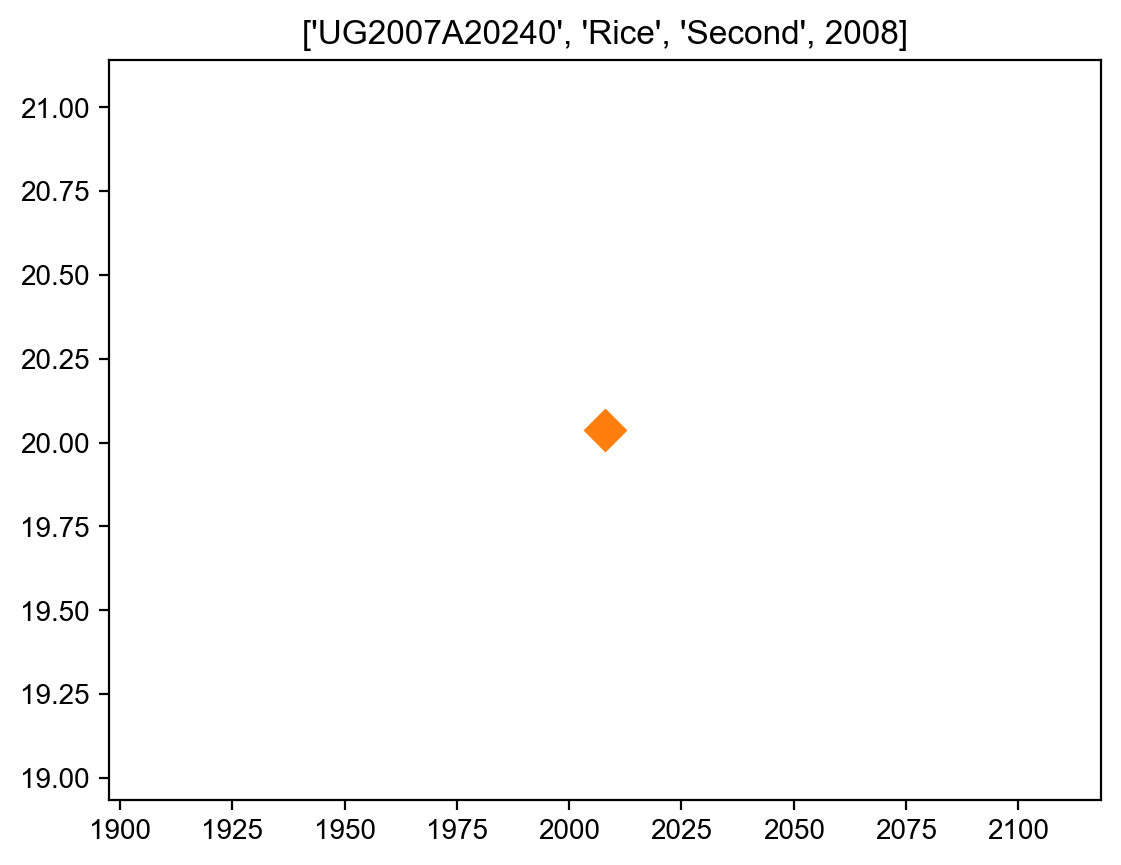

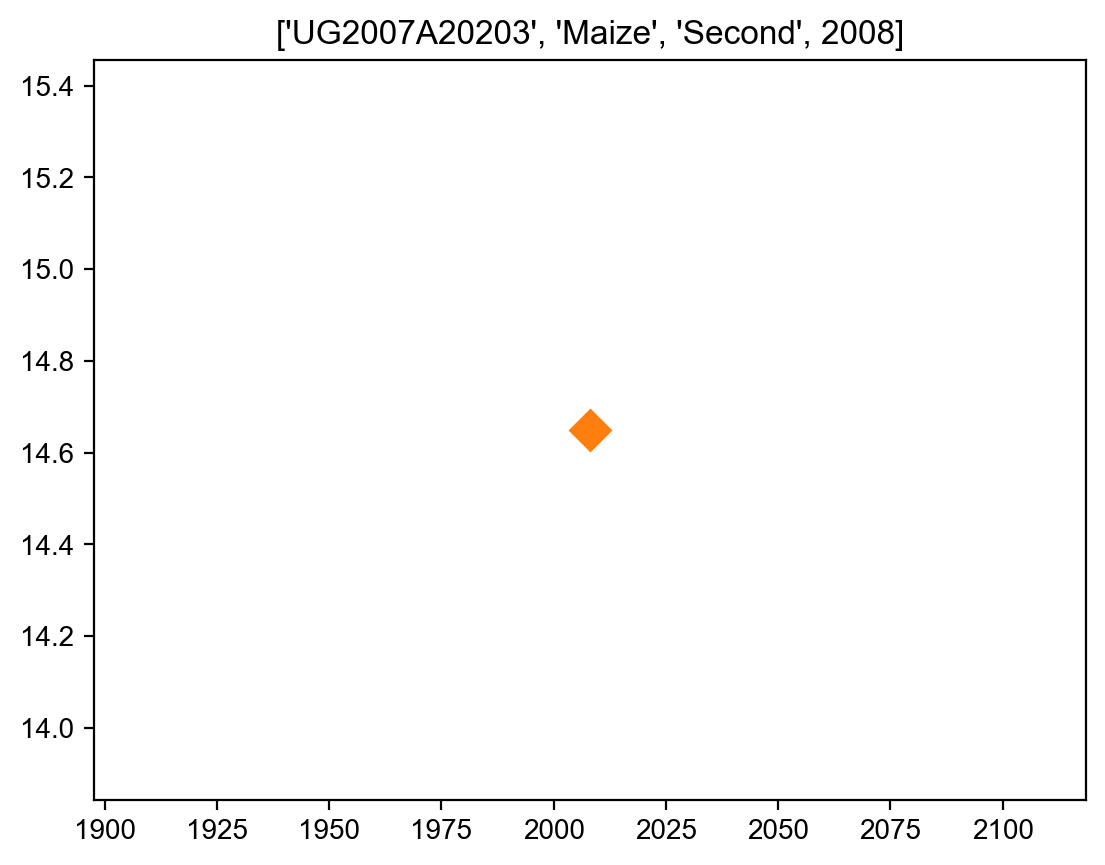

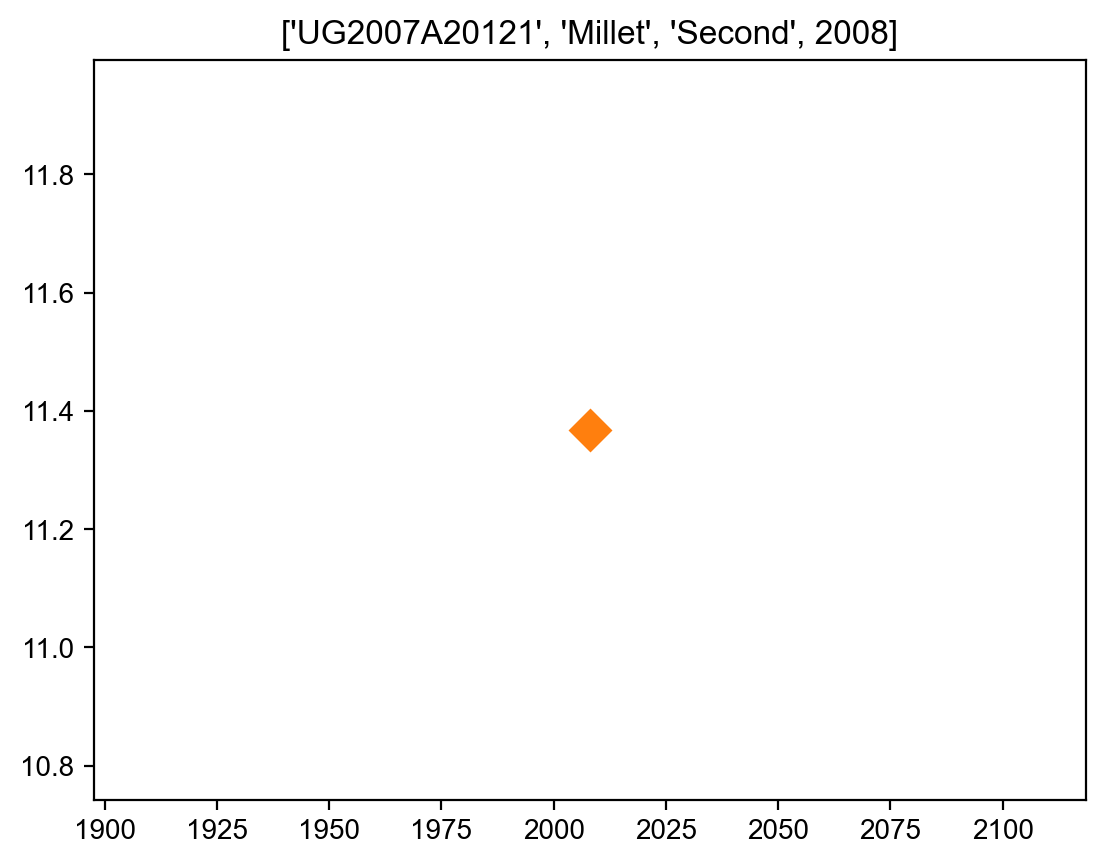

In [6]:
from matplotlib import pyplot as plt

outliers = [['UG2007A20240','Rice','Second',2008],
            ['UG2007A20203','Maize','Second',2008],
            #['UG2007A20202','Maize','First',2009],
            ['UG2007A20121','Millet','Second',2008],
           # ['UG2007A20206','Maize','First',2009],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
   

In [7]:
# Save data
fn_out = '../data/crop/adm_crop_production_UG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

../data/crop/adm_crop_production_UG.csv is saved.


# Visualization of production data

/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


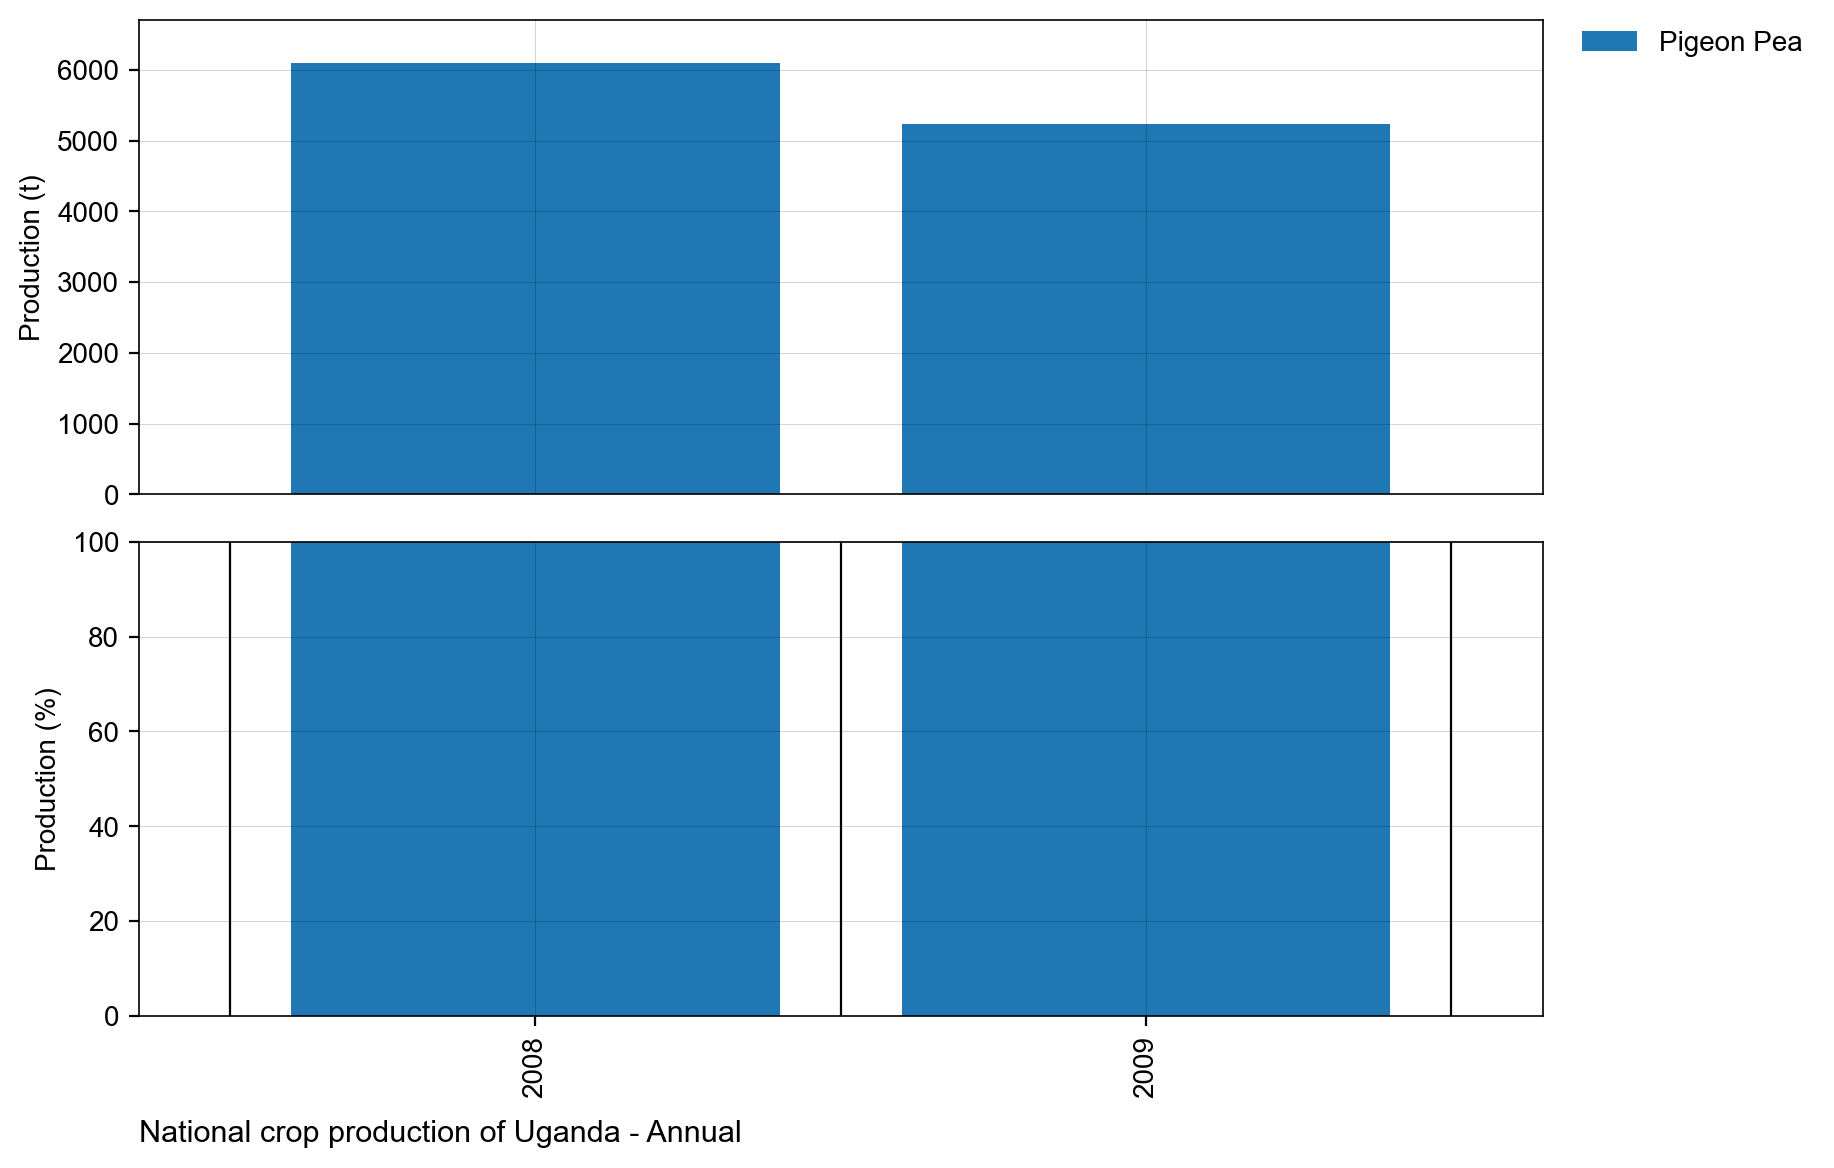

../figures/UG_bar_natgrainprod_Annual.png is saved.


/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


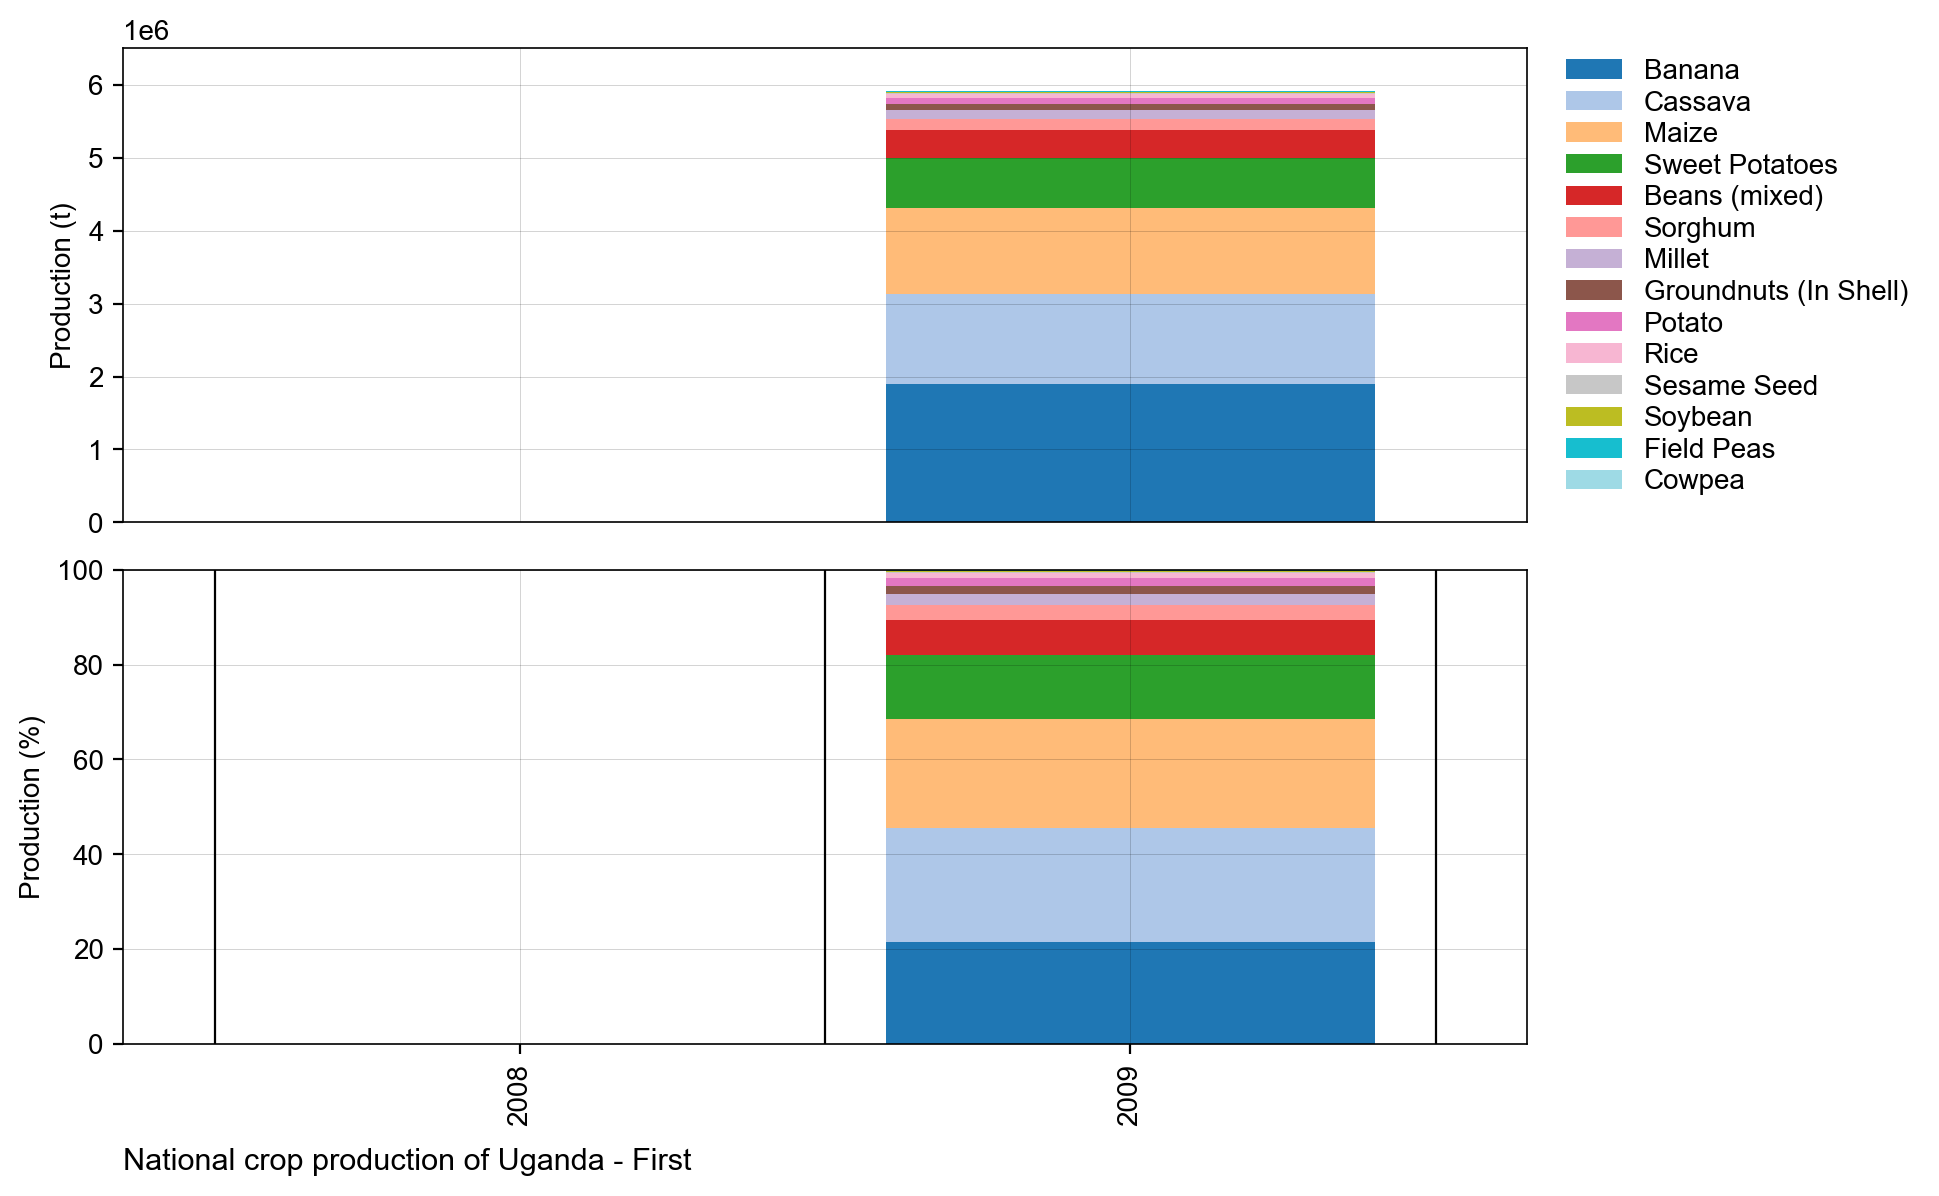

../figures/UG_bar_natgrainprod_First.png is saved.


/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


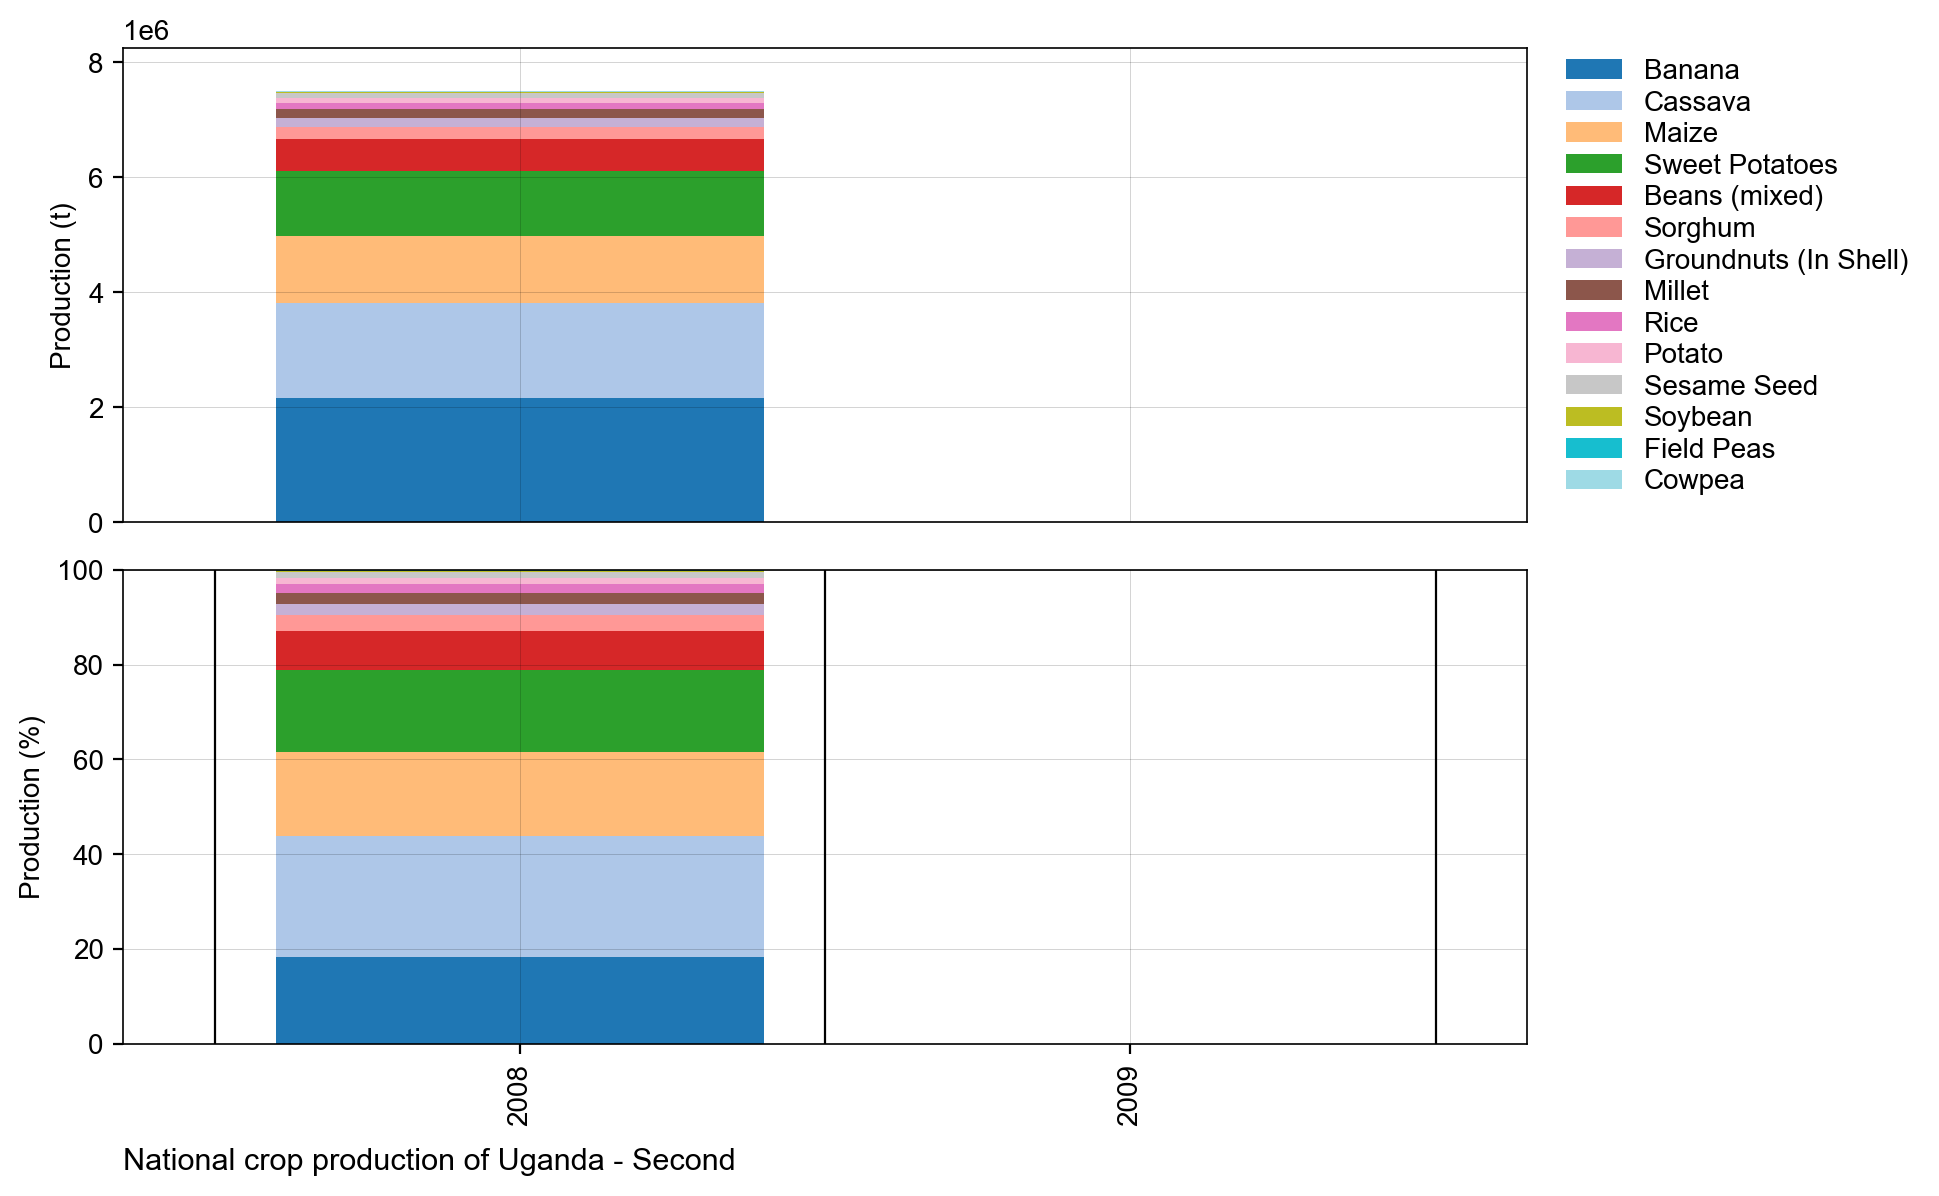

../figures/UG_bar_natgrainprod_Second.png is saved.


In [8]:
# Bar chart of national crop production
country_iso, country_name = 'UG', 'Uganda'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual','First','Second']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

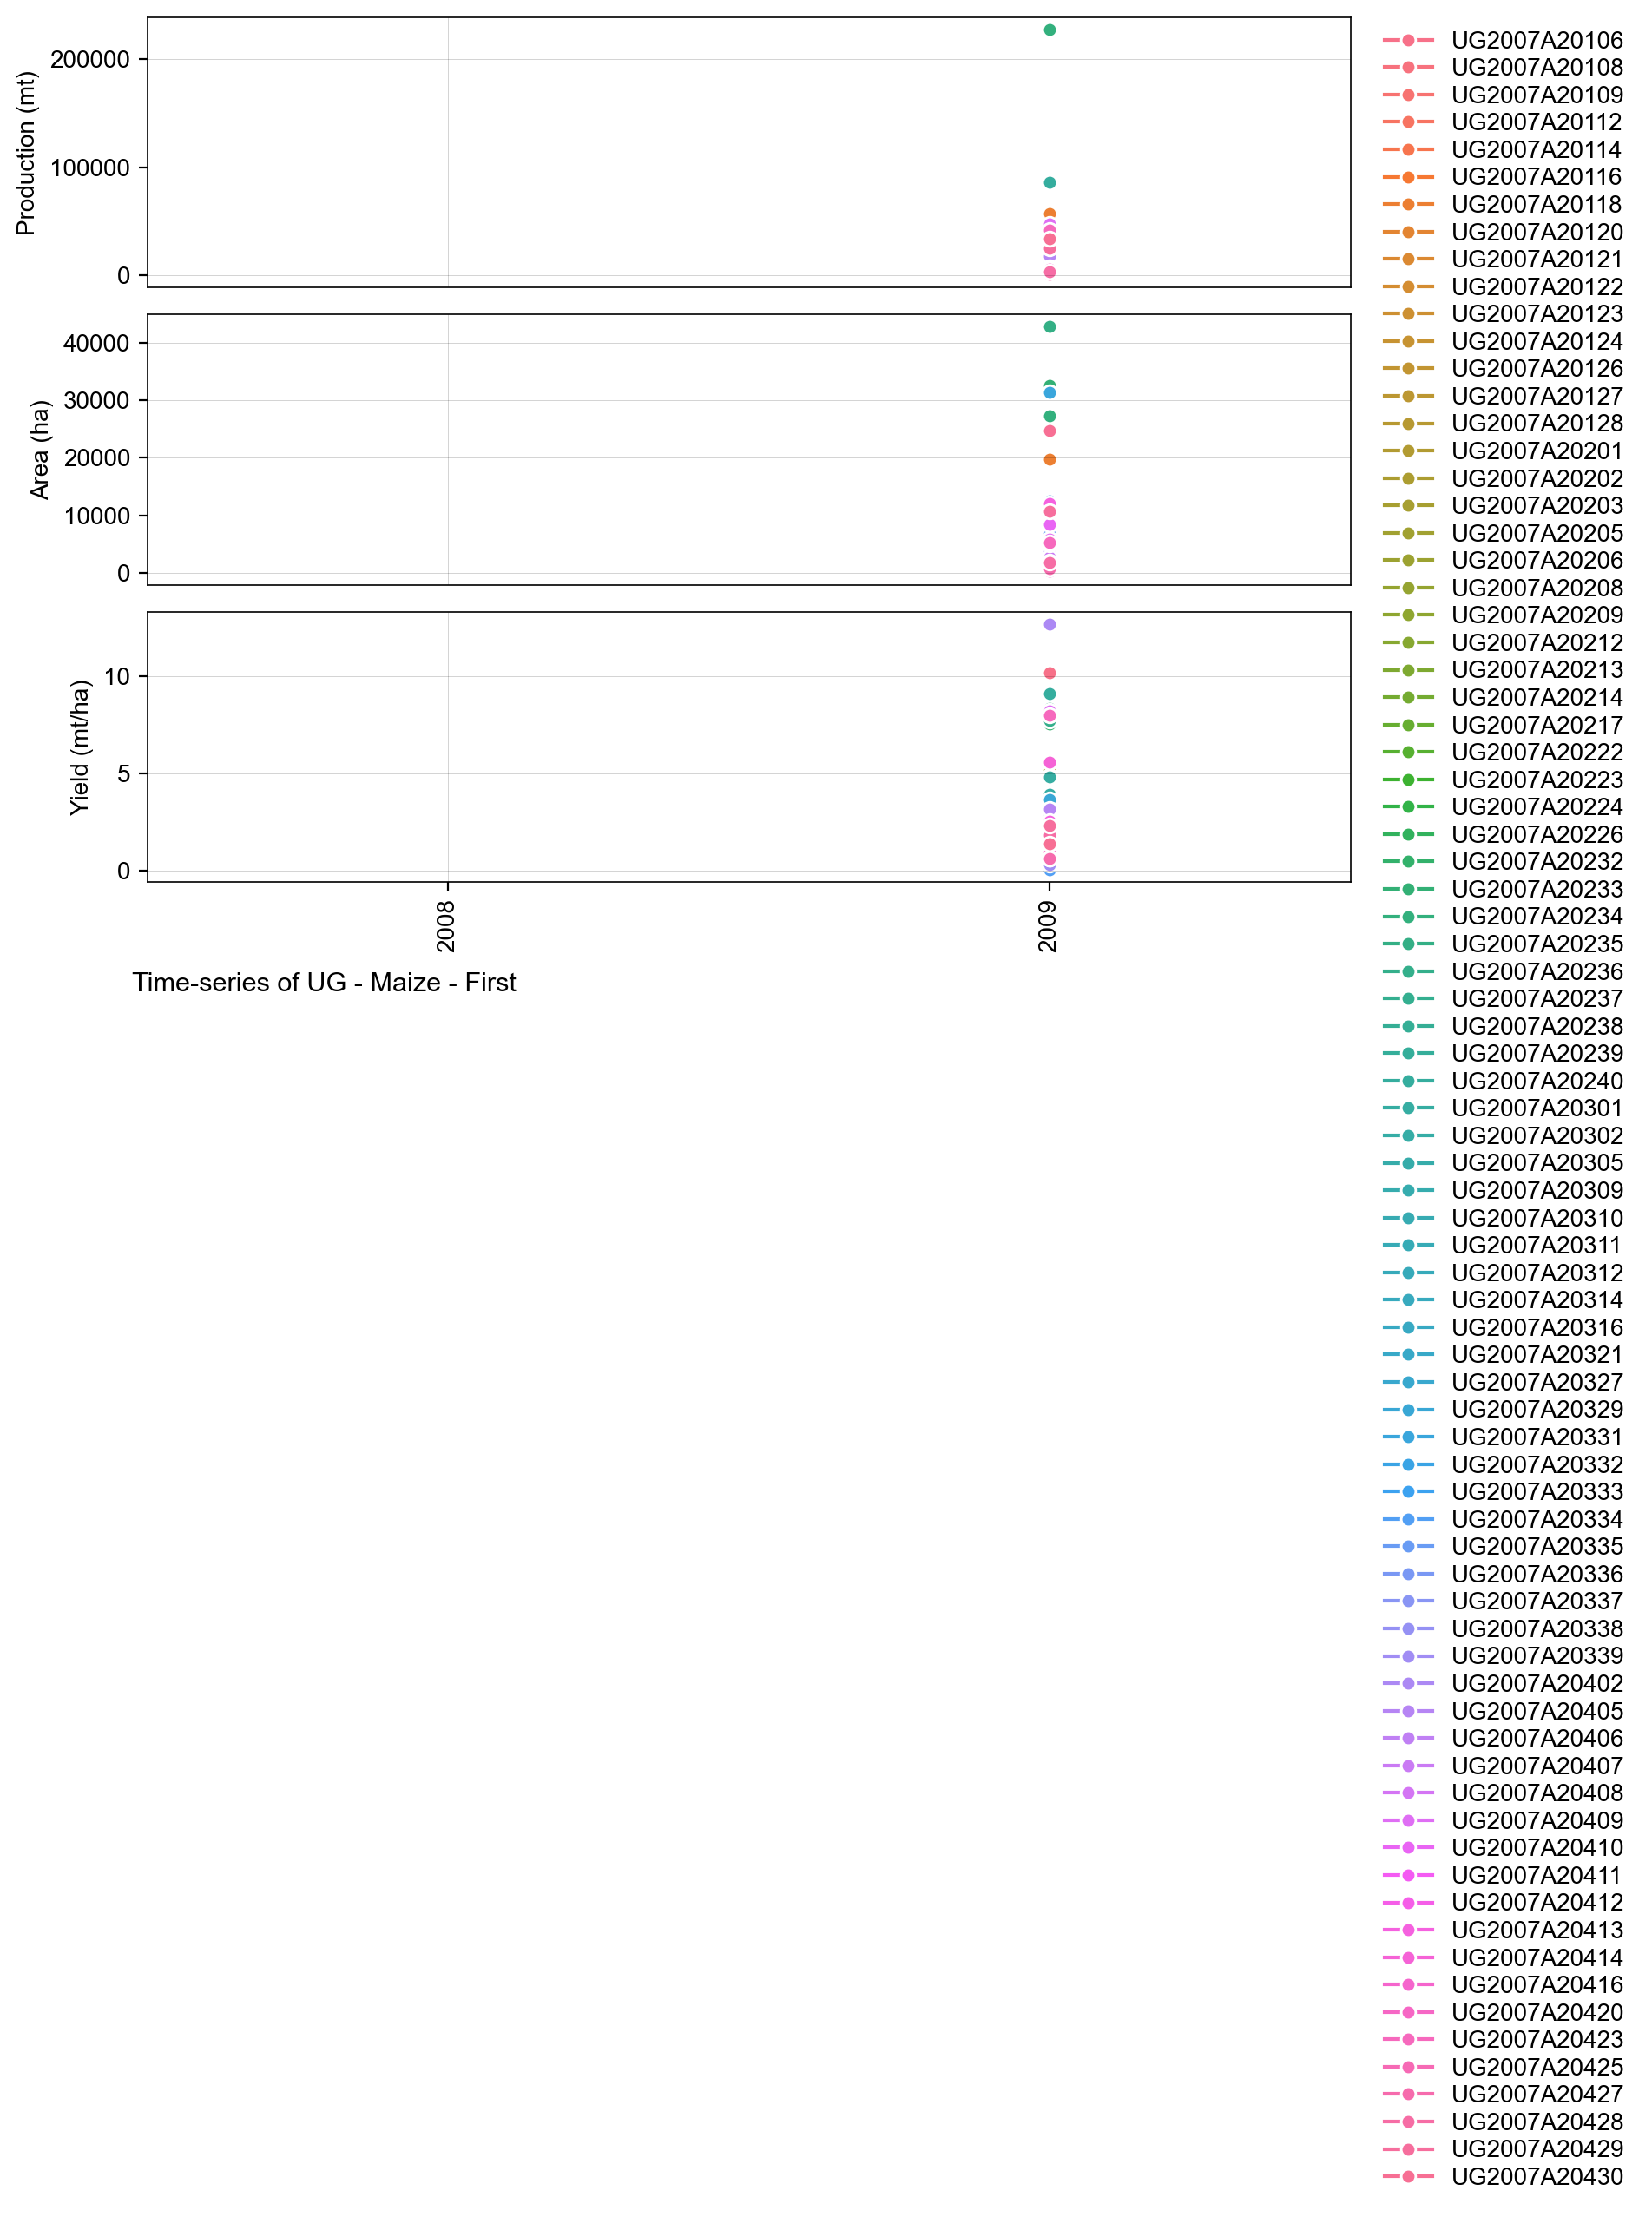

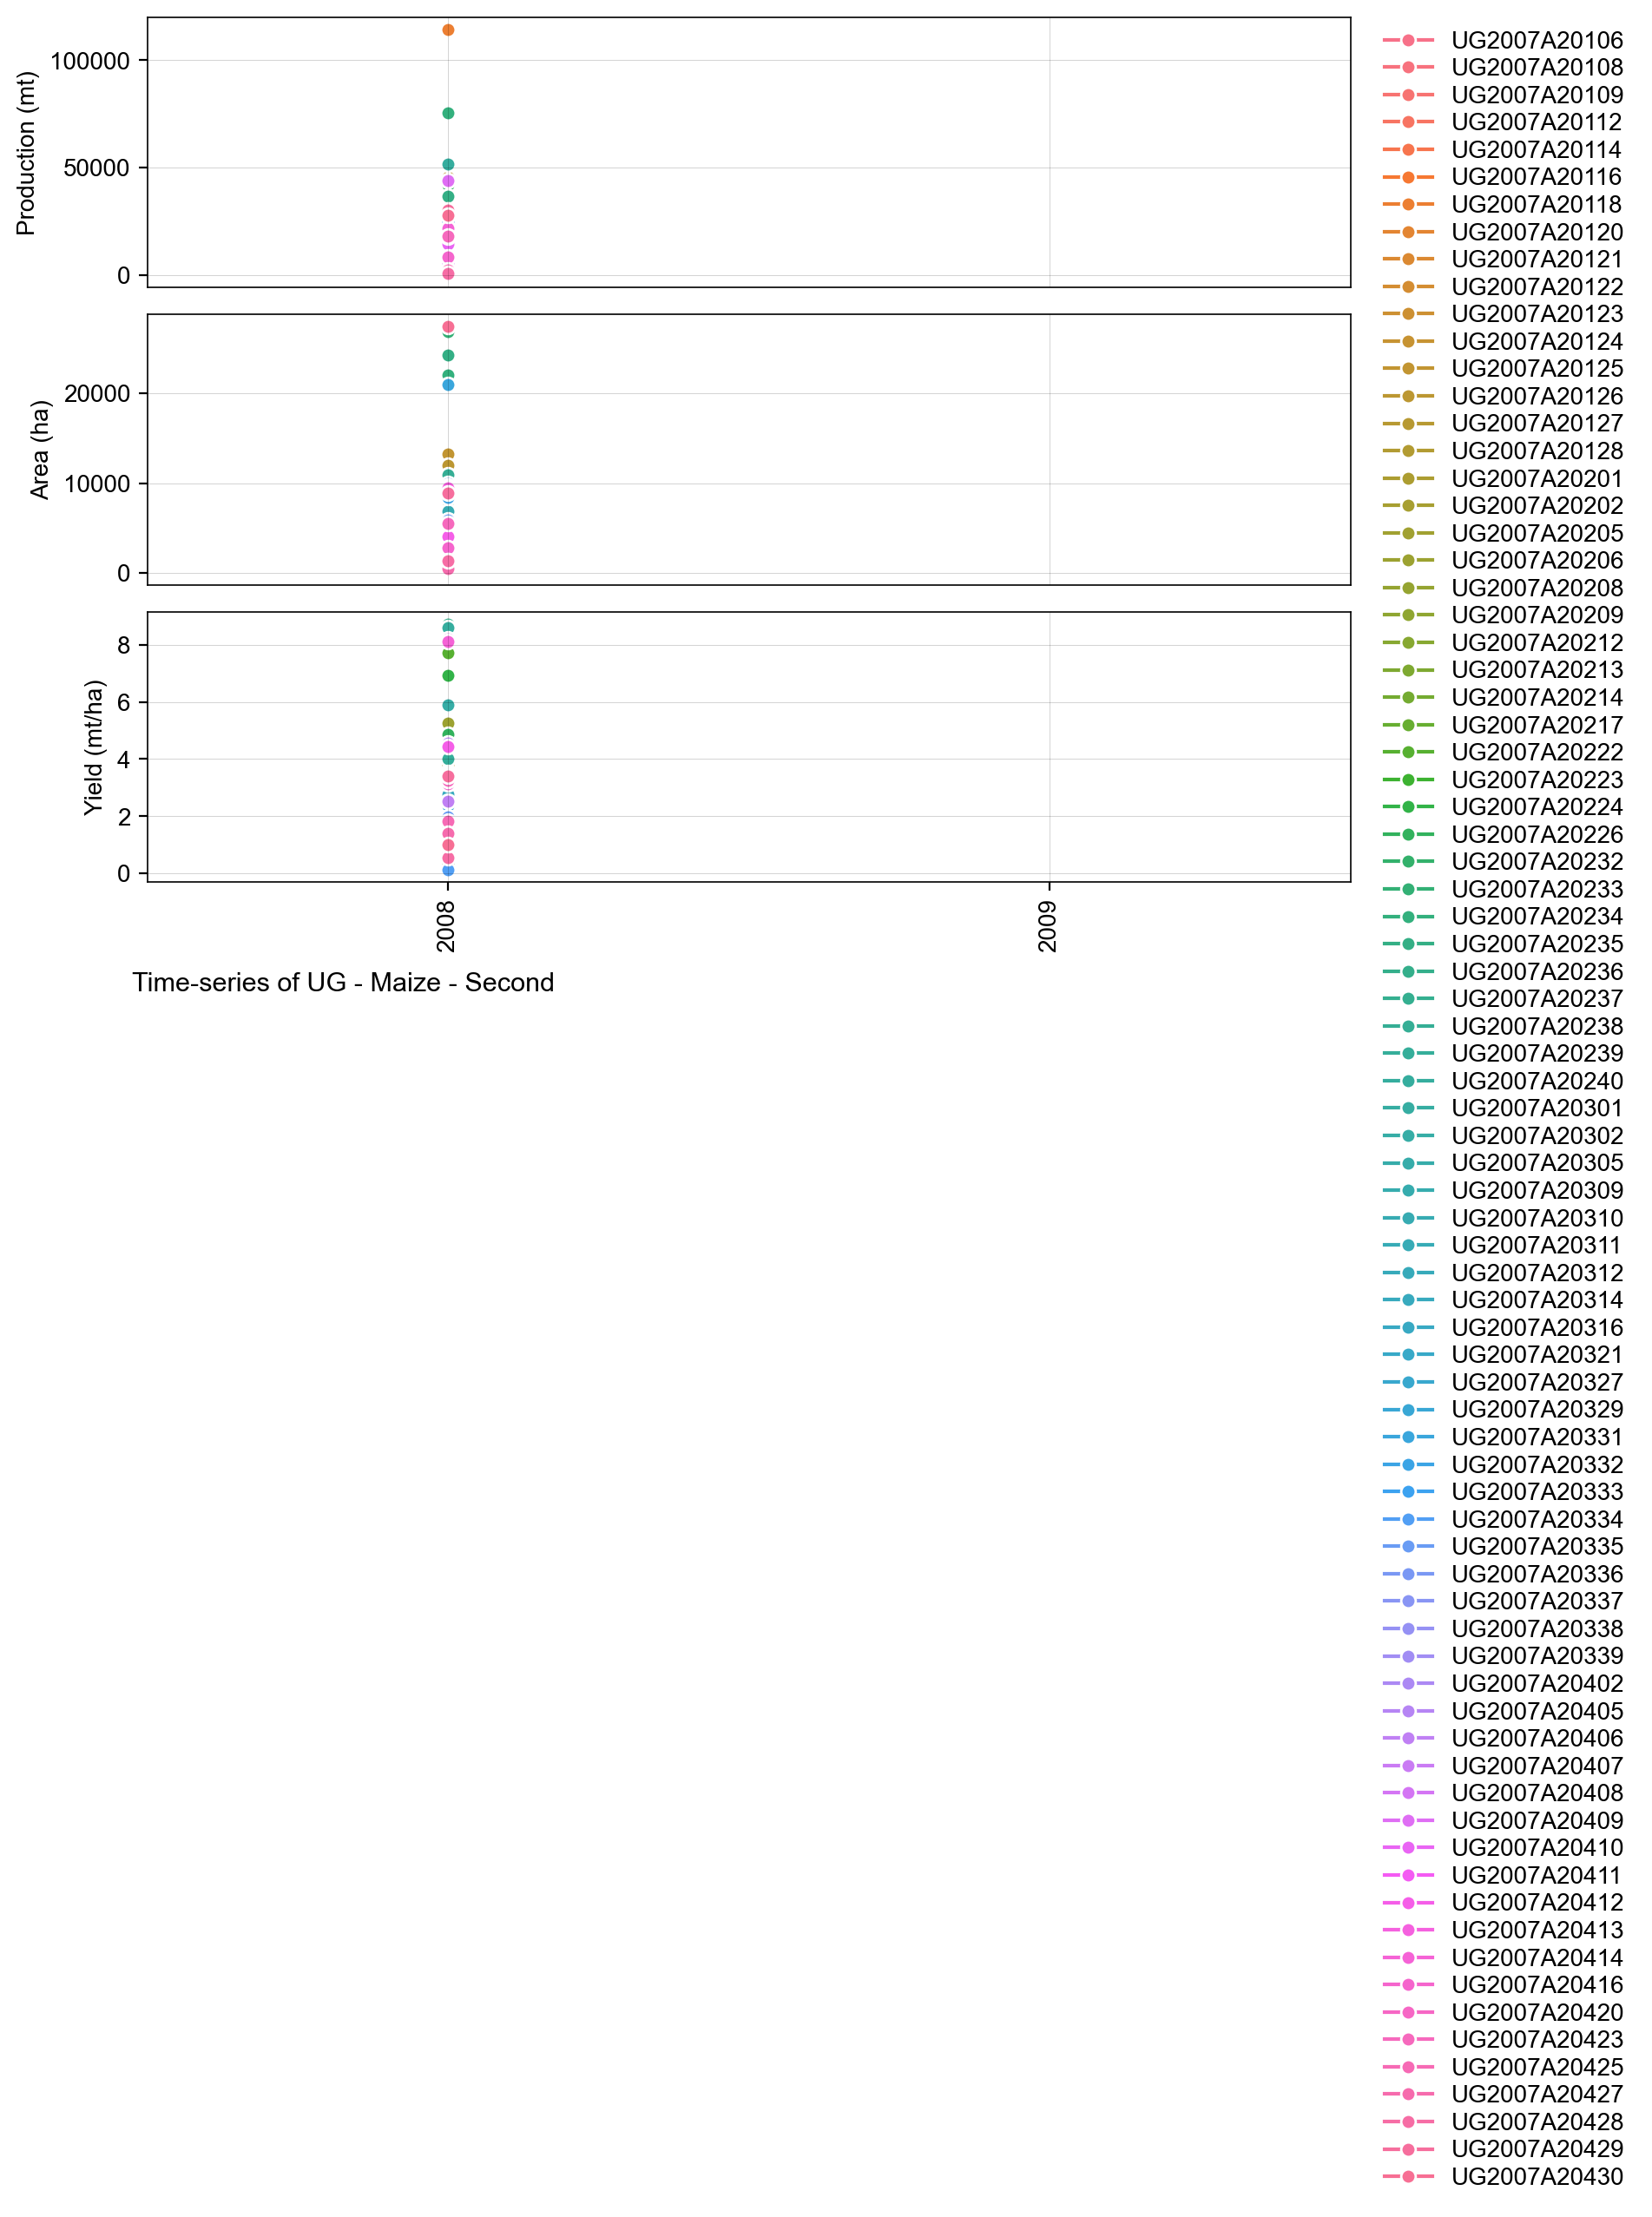

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'UG', 'Uganda'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','First'],
    ['Maize','Second'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)